In [ ]:
langgraph-checkpoint-sqlite

# don't use until error not occurs
msgpack

006_add_memory_long_term_to_agent

<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8" />
  <title>Agentic AI Memory — LTM vs Checkpoints (Quick)</title>
  <meta name="viewport" content="width=device-width, initial-scale=1" />
</head>
<body style="font-family:system-ui,-apple-system,Segoe UI,Roboto,Inter,Arial; line-height:1.5; max-width:860px; margin:24px auto; padding:0 16px;">

  <h2 style="margin:18px 0 8px;">2) Long-Term Memory (LTM)</h2>
  <ul>
    <li><strong>Purpose:</strong> Remember facts, preferences, and past interactions across sessions.</li>
    <li><strong>Where stored:</strong> Durable stores (SQL/SQLite/Postgres) and often embeddings in a vector index.</li>
    <li><strong>How used:</strong> Retrieved (keyword/semantic) and injected into the prompt before the LLM call.</li>
    <li><strong>Example:</strong> “Your name is Raju and you prefer concise answers.”</li>
  </ul>

  <h2 style="margin:18px 0 8px;">3) Execution Memory / Checkpoints</h2>
  <ul>
    <li><strong>Purpose:</strong> Persist workflow state so an agent can resume exactly where it stopped.</li>
    <li><strong>Where stored:</strong> Framework-managed checkpoint backend (e.g., SQLite/Postgres) keyed by a thread/run id.</li>
    <li><strong>How used:</strong> Restores graph/node position and variables; not meant for semantic recall.</li>
    <li><strong>Example:</strong> Job crashed at step 3 of 5; on restart it continues at step 4.</li>
  </ul>

  <h3 style="margin:18px 0 8px;">Key Differences</h3>
  <table style="border-collapse:collapse; width:100%;">
    <thead>
      <tr>
        <th style="text-align:left; border-bottom:1px solid #ddd; padding:8px;">Aspect</th>
        <th style="text-align:left; border-bottom:1px solid #ddd; padding:8px;">Long-Term Memory</th>
        <th style="text-align:left; border-bottom:1px solid #ddd; padding:8px;">Execution / Checkpoints</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Goal</td>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Recall knowledge across sessions</td>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Resume workflow progress</td>
      </tr>
      <tr>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Data</td>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Facts, summaries, embeddings</td>
        <td style="padding:8px; border-bottom:1px dotted #eee;">Graph state, node position, variables</td>
      </tr>
      <tr>
        <td style="padding:8px;">Usage</td>
        <td style="padding:8px;">Retrieved and added to the prompt</td>
        <td style="padding:8px;">Internally restored by the framework</td>
      </tr>
    </tbody>
  </table>
</body>
</html>


REFE: https://pypi.org/project/langgraph-checkpoint-sqlite/<br>https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/

In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_tavily import TavilySearch
from datetime import datetime
from langchain_core.tools import tool
from dotenv import load_dotenv
load_dotenv(override=True)

a:\Indian_AI_Production_5\agentic_ai\agentic_ai_projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

In [ ]:
db_path = r'A:\Indian_AI_Production_5\agentic_ai\agentic_ai_projects\data\memory.db'
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_checkpointer = SqliteSaver(conn)

In [4]:
gpt_model_name = 'gpt-5-2025-08-07'
llm = init_chat_model(gpt_model_name, model_provider='openai')

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State)->State:
    response = llm.invoke(state['messages'])
    return State(messages=response)


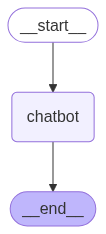

In [6]:
graph_builder.add_node('chatbot', chatbot)

graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

graph = graph_builder.compile(checkpointer=sql_checkpointer)
graph

In [7]:
config = {'configurable': {'thread_id': 'sql_mem_1'}}

In [8]:
graph.invoke({'messages':['I am raju']}, config=config)

{'messages': [HumanMessage(content='I am raju', additional_kwargs={}, response_metadata={}, id='fe97aebd-c744-4e16-b8ed-b4840d51eef3'),
  AIMessage(content='Nice to meet you, Raju! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 216, 'prompt_tokens': 10, 'total_tokens': 226, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C4A9iDq0PvRO10mJbUcFJ6xtaefbC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--776e805d-41cc-4dff-8ce1-a325ca4efa2f-0', usage_metadata={'input_tokens': 10, 'output_tokens': 216, 'total_tokens': 226, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}}),
  HumanMessage(conten

In [20]:
graph.invoke({'messages':['What is my name']}, config=config)

{'messages': [HumanMessage(content='I am raju', additional_kwargs={}, response_metadata={}, id='fe97aebd-c744-4e16-b8ed-b4840d51eef3'),
  AIMessage(content='Nice to meet you, Raju! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 216, 'prompt_tokens': 10, 'total_tokens': 226, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C4A9iDq0PvRO10mJbUcFJ6xtaefbC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--776e805d-41cc-4dff-8ce1-a325ca4efa2f-0', usage_metadata={'input_tokens': 10, 'output_tokens': 216, 'total_tokens': 226, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}}),
  HumanMessage(conten

In [ ]:
sql_checkpointer.

In [8]:
graph.invoke({'messages':['What is my name']}, config=config)

{'messages': [HumanMessage(content='I am raju', additional_kwargs={}, response_metadata={}, id='fe97aebd-c744-4e16-b8ed-b4840d51eef3'),
  AIMessage(content='Nice to meet you, Raju! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 216, 'prompt_tokens': 10, 'total_tokens': 226, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C4A9iDq0PvRO10mJbUcFJ6xtaefbC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--776e805d-41cc-4dff-8ce1-a325ca4efa2f-0', usage_metadata={'input_tokens': 10, 'output_tokens': 216, 'total_tokens': 226, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}}),
  HumanMessage(conten

In [9]:
config_2 = {'configurable':{'thread_id':'sql_mem_2'}}

In [10]:

graph.invoke({'messages':['What is my name']}, config=config_2)

{'messages': [HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='49349c7e-c3bc-4da4-9164-ea2c3b0bc36e'),
  AIMessage(content='I don’t know your name yet. What would you like me to call you?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 10, 'total_tokens': 164, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C4APUunAaeIbHkhAJpmOZ5wbyJERg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f3d8f1de-93f4-47fc-a7c6-504609c1e308-0', usage_metadata={'input_tokens': 10, 'output_tokens': 154, 'total_tokens': 164, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 128}}),
 

In [10]:
graph.invoke({'messages':['I am kaju']}, config=config_2)

{'messages': [HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='49349c7e-c3bc-4da4-9164-ea2c3b0bc36e'),
  AIMessage(content='I don’t know your name yet. What would you like me to call you?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 10, 'total_tokens': 164, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C4APUunAaeIbHkhAJpmOZ5wbyJERg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f3d8f1de-93f4-47fc-a7c6-504609c1e308-0', usage_metadata={'input_tokens': 10, 'output_tokens': 154, 'total_tokens': 164, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 128}}),
 

In [ ]:
# Get latest state for a thread_id
snap1 = graph.get_state(config)          # {'configurable': {'thread_id': 'sql_mem_1'}}
print("sql_mem_1 messages:")
print(snap1.values.get("messages", []))

sql_mem_1 messages:
[HumanMessage(content='I am raju', additional_kwargs={}, response_metadata={}, id='fe97aebd-c744-4e16-b8ed-b4840d51eef3'), AIMessage(content='Nice to meet you, Raju! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 216, 'prompt_tokens': 10, 'total_tokens': 226, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C4A9iDq0PvRO10mJbUcFJ6xtaefbC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--776e805d-41cc-4dff-8ce1-a325ca4efa2f-0', usage_metadata={'input_tokens': 10, 'output_tokens': 216, 'total_tokens': 226, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}}), HumanMessage(con

In [18]:
# Get latest state for a thread_id
snap1 = graph.get_state(config_2)          # {'configurable': {'thread_id': 'sql_mem_1'}}
print("sql_mem_1 messages:")
print(snap1.values.get("messages", []))

sql_mem_1 messages:
[HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='49349c7e-c3bc-4da4-9164-ea2c3b0bc36e'), AIMessage(content='I don’t know your name yet. What would you like me to call you?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 10, 'total_tokens': 164, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C4APUunAaeIbHkhAJpmOZ5wbyJERg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f3d8f1de-93f4-47fc-a7c6-504609c1e308-0', usage_metadata={'input_tokens': 10, 'output_tokens': 154, 'total_tokens': 164, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 128}